In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data Processing

In [2]:
target_url = 'https://www.ndbc.noaa.gov/data/realtime2/KIKT.txt'
df = pd.read_csv(target_url, sep='\s+')
df = df[1:]
df = df.drop(['WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'WTMP', 'PTDY', 'TIDE', 'GST'], axis=1)
df = df.replace(['MM'],'nan')
rest = df.iloc[:,5:].astype(float)
first = df.iloc[:,:5]
df = pd.concat([first, rest],axis=1)
df.rename(columns = {'#YY':'YY'},inplace=True)
df['date'] = df['YY']+'-'+df['MM']+'-'+df['DD']
df['time'] = df['hh']+':'+df['mm']
df['datetime'] = pd.to_datetime(df['date']+' '+df['time'])
df=df[1:]

In [3]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
dts = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in 
       datetime_range(datetime(2021, 12, 2, 22, 35), datetime(2021, 12, 21, 20, 15),timedelta(minutes=20))]
dts.sort(reverse=True)
df2=pd.DataFrame()
df2['datetime'] = pd.to_datetime(dts)
df1 = df2.merge(df, on='datetime', how='left')

In [4]:
df1.interpolate(limit_direction="both",inplace=True)
df1 = df1.drop(['YY', 'MM', 'DD', 'hh', 'mm', 'date', 'time'], axis=1)
df1.set_index('datetime',inplace = True)
df1

,WDIR,WSPD,ATMP,DEWP,VIS
datetime,,,,,
2021-12-21 19:55:00,300.0,3.6,15.0,10.0,8.7
2021-12-21 19:35:00,300.0,3.1,15.0,10.0,8.7
2021-12-21 19:15:00,300.0,4.1,16.0,10.0,8.7
2021-12-21 18:55:00,300.0,3.1,16.0,10.0,8.7
2021-12-21 18:35:00,300.0,2.6,16.0,10.0,8.7
...,...,...,...,...,...
2021-12-02 23:55:00,230.0,0.0,21.0,16.0,8.7
2021-12-02 23:35:00,230.0,0.0,21.0,16.0,8.7
2021-12-02 23:15:00,230.0,0.0,21.0,16.0,8.7


# Exploratory Data Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc539e70cd0>,
      dtype=object)

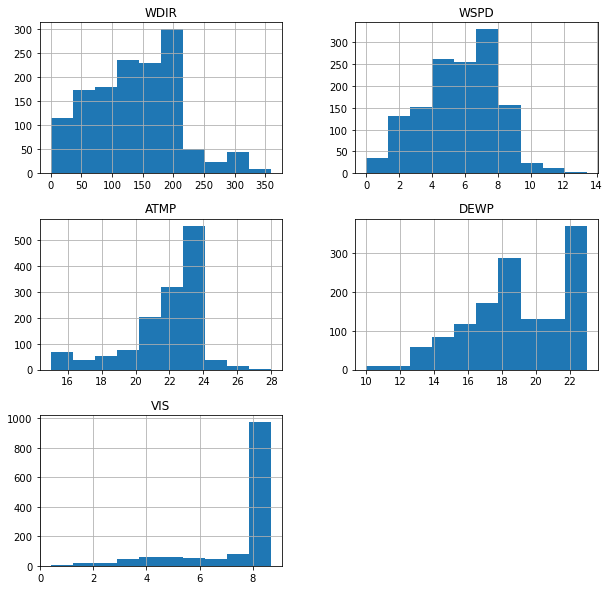

In [5]:
## Histogram
df1.hist(bins=10,figsize=(10, 10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc53a149970>,
      dtype=object)

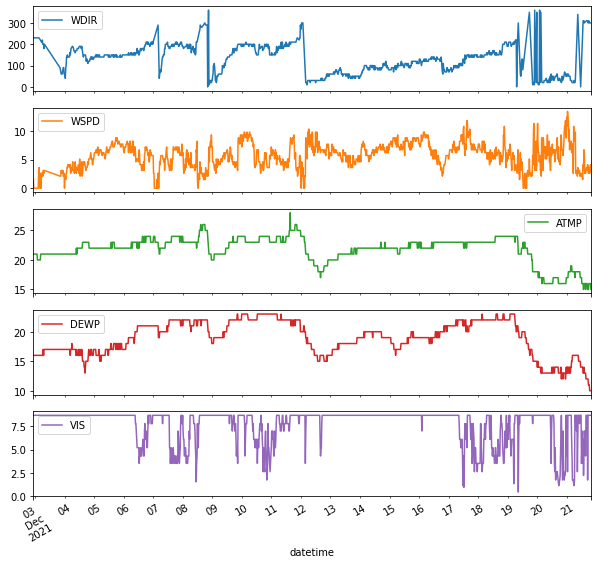

In [6]:
## time series plot
df1.plot(subplots=True,figsize=(10, 10))

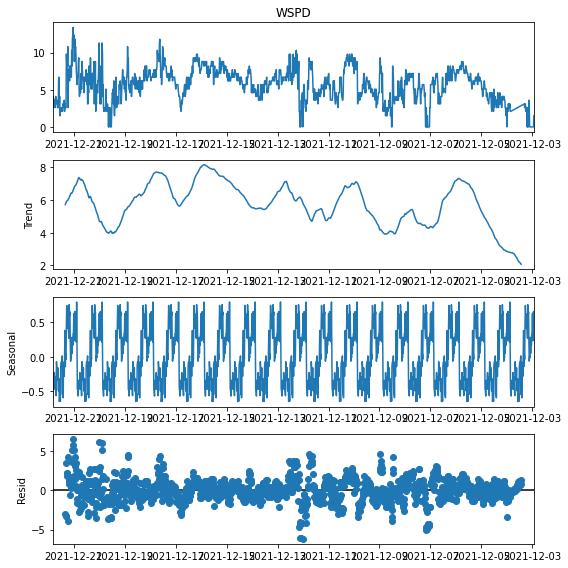

In [7]:
## time series decomposition: WSPD
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 8, 8
WSPD_dec = sm.tsa.seasonal_decompose(df1['WSPD'], model='Additive',period = 3*24)
fig = WSPD_dec.plot()
plt.show()

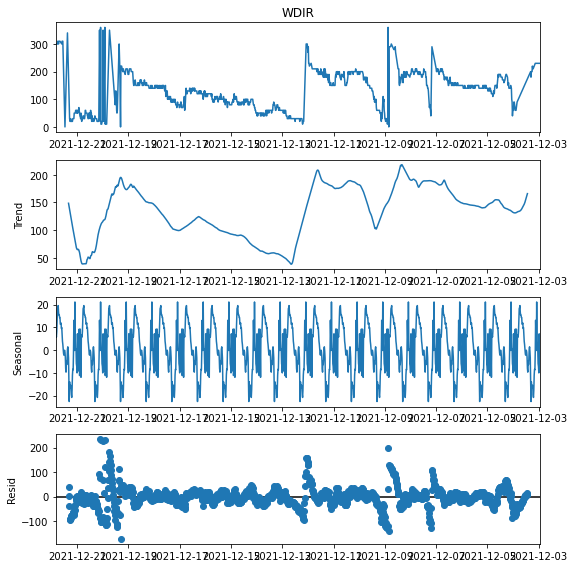

In [8]:
WDIR_dec = sm.tsa.seasonal_decompose(df1['WDIR'], model='Additive',period = 3*24)
fig = WDIR_dec.plot()
plt.show()

# Forecasting: ARIMA(p, q, d) model

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy import signal

"""
Train - Test Split
"""
row = 72*3
df1 = df1[::-1]
train = df1[:][:-row]
test = df1[:][-row:]

## Stationary Testing: Finding d

In [10]:
def test_stationarity(timeseries, window=12):
    df = pd.DataFrame(timeseries)
    df['Rolling.Mean'] = timeseries.rolling(window=window).mean()
    df['Rolling.Std']=timeseries.rolling(window=window).std()
    adftest = sm.tsa.stattools.adfuller(timeseries)
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistics','p-value','#lags used','#Observation used'])
    for key,value in adftest[4].items():
        adfoutput['critical value (%s)'% key] = value
    return adfoutput, df

The test of data stability:
Test Statistics           -4.621360
p-value                    0.000118
#lags used                 5.000000
#Observation used       1139.000000
critical value (1%)       -3.436104
critical value (5%)       -2.864081
critical value (10%)      -2.568123
dtype: float64


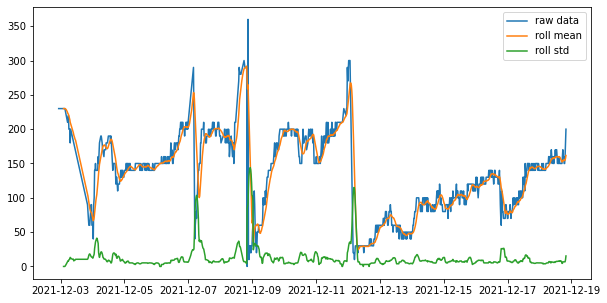

In [11]:
fig = plt.figure(figsize=(10, 5))
adftest, dftest0 = test_stationarity(train['WDIR'])
plt.plot(dftest0)
plt.legend(["raw data", "roll mean", "roll std"])
print('The test of data stability:')
print(adftest)

The test of data stability:
Test Statistics        -5.655233e+00
p-value                 9.654935e-07
#lags used              2.000000e+00
#Observation used       1.142000e+03
critical value (1%)    -3.436089e+00
critical value (5%)    -2.864074e+00
critical value (10%)   -2.568119e+00
dtype: float64


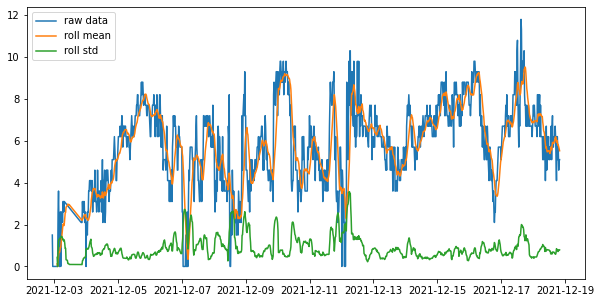

In [12]:
fig = plt.figure(figsize=(10, 5))
adftest, dftest0 = test_stationarity(train['WSPD'])
plt.plot(dftest0)
plt.legend(["raw data", "roll mean", "roll std"])
print('The test of data stability:')
print(adftest)

Our null hypotheis H0: the time series is non-stationary.\
As we can see from the above two tests, they all have small p-value.\
Therefore, we reject H0, conclude that for both WSPD and WDIR they are all stationary!\
This also implies that for ARIMA(p,q,d), d = 0. i.e. we don't need to difference the series

## PACF Plot: Finding p

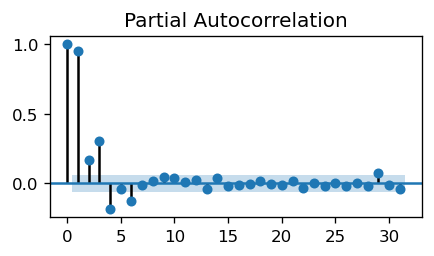

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(4,2), 'figure.dpi':120})

pacf_WDIR = plot_pacf(train['WDIR'], method = 'ywm')

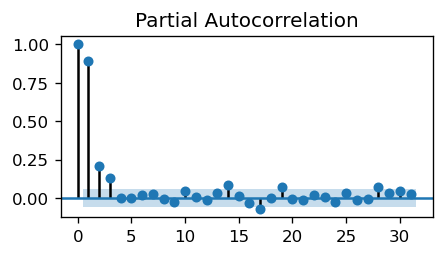

In [14]:
pacf_WSPD = plot_pacf(train['WSPD'], method = 'ywm')

As we can ovserve that the PACF lag 1 is quite significant since is well above the significance line.

Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region).

But we are going to be conservative therefore fix the p as 1 for both WDIR and WSPD.

## ACF Plot: Finding q

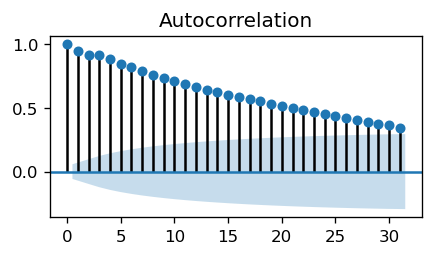

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

acf_WDIR = plot_acf(train['WDIR'])

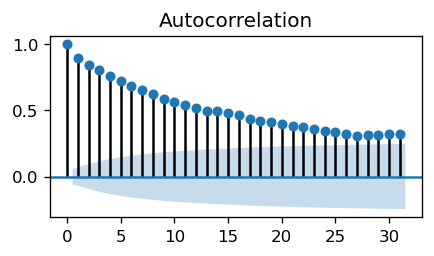

In [16]:
acf_WSPD = plot_acf(train['WSPD'])

As we can ovserve that the ACF lag 1-25 is quite significant for WDIR while ACF lag 1-20 is quite significant for WSPD .

So we are going to set q_WDIR = 25 and q_WSPD = 20.

## Building ARIMA

In [17]:
from statsmodels.tsa.arima_model import ARIMA

model_WDIR = ARIMA(train['WDIR'], order=(1,0,25))
res_WDIR = model_WDIR.fit()

/Users/zayn.w/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 20T will be used.
  warnings.warn('No frequency information was'


In [18]:
print("WDIR ARIMA model:\n", res_WDIR.summary())

WDIR ARIMA model:
                               ARMA Model Results                              
Dep. Variable:                   WDIR   No. Observations:                 1145
Model:                    ARMA(1, 25)   Log Likelihood               -4841.157
Method:                       css-mle   S.D. of innovations             16.572
Date:                Sat, 29 Jan 2022   AIC                           9738.315
Time:                        11:42:45   BIC                           9879.523
Sample:                    12-02-2021   HQIC                          9791.630
                         - 12-18-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         142.1597     13.090     10.861      0.000     116.505     167.815
ar.L1.WDIR      0.9602      0.020     47.767      0.000       0.921       1.000
ma.L1.WDIR     -0.1783      0

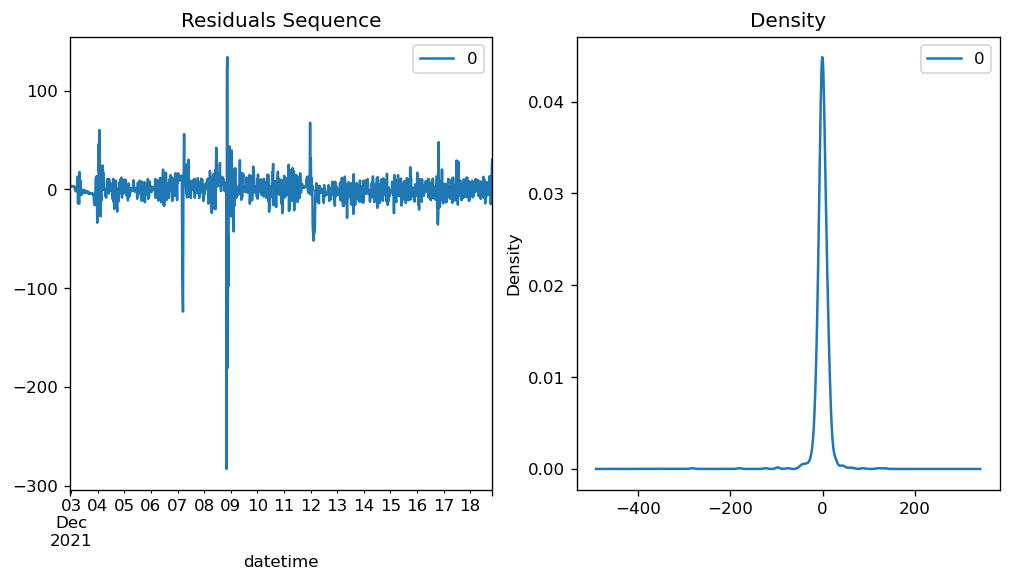

In [100]:
# Plot residual errors
resi_WDIR = pd.DataFrame(res_WDIR.resid)
fig, ax = plt.subplots(1,2)

plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':120})
resi_WDIR.plot(title = 'Residuals Sequence', ax = ax[0])
resi_WDIR.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

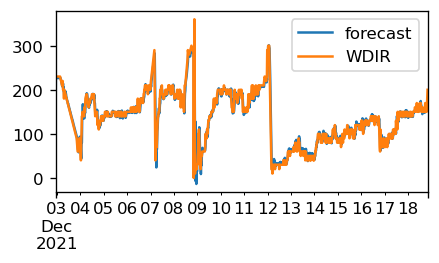

In [20]:
res_WDIR.plot_predict(dynamic = False)
plt.show()

The residual error seem great since it is mostly zero mean and uniform variance.

Meanwhile, the actual against the fitted values seems also highly corresponded!

## Out-of-Time Cross Validation

In [29]:
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'me':me, 'mae': mae, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

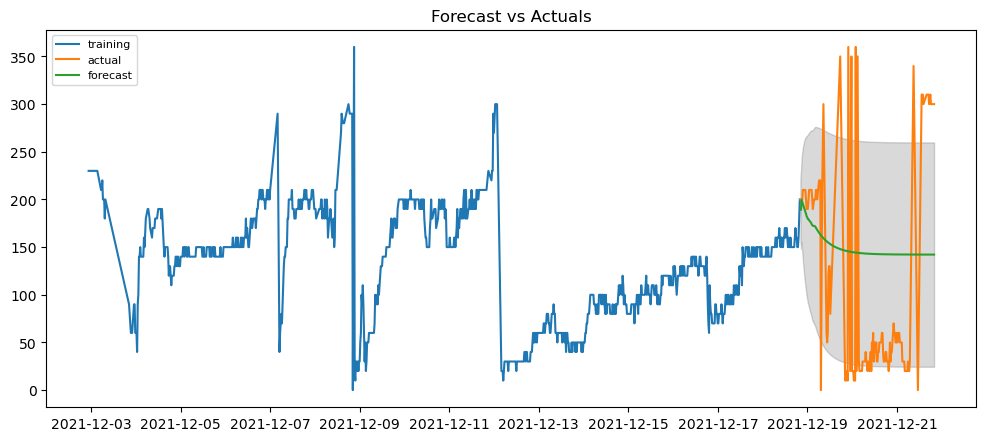

In [30]:
# Forecast
fc, se, conf = res_WDIR.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['WDIR'], label='training')
plt.plot(test['WDIR'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
forecast_accuracy(fc,test['WDIR'])

<ipython-input-29-fd2f76c28298>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-29-fd2f76c28298>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


{'me': 16.046807424583204,
 'mae': 94.19319179781775,
 'rmse': 106.65619521786302,
 'corr': 0.29259088354003504,
 'minmax': 0.5236434731415227}

# SARIMA with Exogenous Variable

In [86]:
import pandas as pd
import pmdarima as pm

def forecast(history):
    """
    WDIR
    """
    tr_extro_WDIR = history.loc[:, history.columns != 'WDIR']
    xmodel_WDIR = pm.arima.auto_arima(y = history["WDIR"], X = tr_extro_WDIR, 
                           start_p = 2, max_p = 5,
                           start_q = 10, max_q = 25)
    
    # Forecast
    WDIR_pred, confit_WDIR = xmodel_WDIR.predict(n_periods = 72*3, X = tr_extro_WDIR.iloc[-72*3:],return_conf_int=True)

    # Make as pandas series
    fc_WDIR = pd.Series(WDIR_pred, index =test.index)
    lower_WDIR = pd.Series(confit_WDIR[:, 0], index = test.index)
    upper_WDIR = pd.Series(confit_WDIR[:, 1], index = test.index)
    
    """
    WSPD
    """
    tr_extro_WSPD = history.loc[:, history.columns != 'WSPD']
    xmodel_WSPD = pm.arima.auto_arima(y = history["WSPD"], X = tr_extro_WSPD, 
                               start_p = 2, max_p = 5,
                               start_q = 10, max_q = 25) 

    # xmodel_WSPD.summary()
    # Forecast
    WSPD_pred, confit_WSPD = xmodel_WSPD.predict(n_periods = 72*3, X = tr_extro_WSPD.iloc[-72*3:],return_conf_int=True)

    # Make as pandas series
    fc_WSPD = pd.Series(WSPD_pred, index =test.index)
    lower_WSPD = pd.Series(confit_WSPD[:, 0], index = test.index)
    upper_WSPD = pd.Series(confit_WSPD[:, 1], index = test.index)
    
    return fc_WDIR,lower_WDIR,upper_WDIR,fc_WSPD,lower_WSPD,upper_WSPD

In [ ]:
# Plot WDIR forecasing
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['WDIR'], label='training')
plt.plot(fc_WDIR, label='forecast')
plt.fill_between(lower_WDIR.index, lower_WDIR, upper_WDIR, 
                 color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Plot WSPD fore casting
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['WSPD'], label='training')
plt.plot(fc_WSPD, label='forecast')
plt.fill_between(lower_WSPD.index, lower_WSPD, upper_WSPD, 
                 color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()